In [1]:
import numpy as np
import pickle
import torch

from sklearn.preprocessing import Normalizer
from model1 import CNN as CNN1
from model2 import CNN as CNN2
from model_CNN9 import CNN as CNN3

import matplotlib.pyplot as plt
import seaborn as sns

/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.set_color_codes('dark')
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=1.5)
plt.rc('font', size=25)  

In [3]:
model1 = CNN1(input_features=2,num_classes=1)
model2 = CNN2(input_features=1,num_classes=1)
model3 = CNN3(input_features=1,num_classes=1)


model1.load_state_dict(torch.load('../../models/Data_based_models/CNN_f5/model_saves/model_0_49.h5'))
model2.load_state_dict(torch.load('../../models/Data_based_models/Self_Attention/model_saves2/model_0_39.h5'))
model3.load_state_dict(torch.load('../../models/Data_based_models/CNN9/model_saves/model_0_39.h5'))


norm1=pickle.load(open('../../models/Data_based_models/CNN_f5/normalizer.pickle','rb'))
norm2=pickle.load(open('../../models/Data_based_models/CNN9/normalizer.pickle','rb'))

In [4]:
def split1(data):
    w_samples =int(1*100)
    interval=0.5
    sample_rate=200
    X=np.array([data[-w_samples+i:i] for i in range(w_samples*2,data.shape[0]-2*w_samples,int(interval*sample_rate))])
    X=X[:,:,[0,1]].reshape(-1,2,w_samples) 
    X=norm1.transform(X.reshape(X.shape[0],-1)).reshape(-1,2,w_samples)
    return X

def split2(data):
    w_samples =int(2*100)
    interval=0.5
    sample_rate=200
    X=np.array([data[-w_samples+i:i] for i in range(w_samples,data.shape[0]-w_samples,int(interval*sample_rate))])
    X=X[:,:,[0]].reshape(-1,1,w_samples)
    X=X.reshape(X.shape[0],-1)
    X=norm2.transform(X).reshape(-1,1,w_samples) 
    return X

In [5]:
run=1
path=f'../../Recordings/sub-P008/pickled_data/Session1/{run}.pickle'
with open(path,'rb') as f:
    d=pickle.load(f)
    data=d['data']

X1=split2(data)
X2=split2(data)

print(X1.shape,X2.shape)

(593, 1, 200) (593, 1, 200)


In [6]:
model1.eval()
model2.eval()
preds1=[]
preds2=[]
with torch.no_grad():
    for i in range(X1.shape[0]):
        x1=torch.from_numpy(X1[i,:,:]).float().unsqueeze(0)
        out1=model2(x1)
        out2=model3(x1)
        preds1+=out1.detach().cpu()
        preds2+=out2.detach().cpu()

        


    

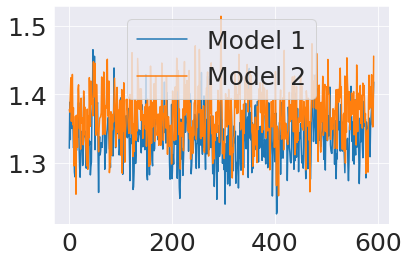

In [7]:
plt.plot(preds1,label='Model 1')
plt.plot(preds2,label='Model 2')
plt.legend()
plt.show()


In [8]:
def Kalman_1D(state,actual_state,measurement,process_var=0.05**2,measurement_var=0.07**2):
        estimate=[[],[]]
        state[0],state[1]=actual_state+0,state[1]+process_var
        estimate[0],estimate[1]=(state[1]*measurement+measurement_var*state[0])/(state[1]+measurement_var),(state[1]*measurement_var)/(state[1]+measurement_var)
        state=estimate

        return state

def kalman_filter(preds1,preds2):
    values=[]
    for i,v in enumerate(preds1):
        if i==0:
            state=[v,0.1**2]
            values+=[state[0]]
        else:
            state=Kalman_1D(state,v,preds2[i])
            values+=[state[0]]
    return values

In [9]:
values=kalman_filter(preds2,preds1)

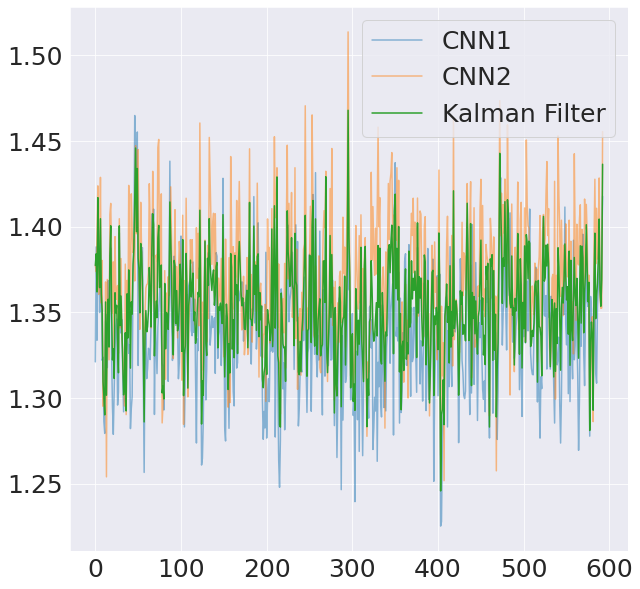

In [10]:
plt.figure(figsize=(10,10))
plt.plot(preds1,label='CNN1',alpha=0.5)
plt.plot(preds2,label='CNN2',alpha=0.5)
plt.plot(values,label='Kalman Filter')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mse=mean_squared_error(1.3*np.ones(len(values)),values)
mse1=mean_squared_error(1.3*np.ones(len(preds1)),preds1)
mse2=mean_squared_error(1.3*np.ones(len(preds2)),preds2)

print(np.sqrt(mse),np.sqrt(mse1),np.sqrt(mse2))

0.061546278299276225 0.05257326760848398 0.07936887319000892
